In [1]:
!nvidia-smi

Fri Apr 18 22:09:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              8W /   45W |     410MiB /   4096MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-25 21:27:50.455876: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 21:27:50.705316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745591270.790903     632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745591270.814171     632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 21:27:50.997500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Binary Convolutional Layer with STE
class BinaryConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding='same', **kwargs):
        super(BinaryConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        # Full-precision weights storage
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BinaryConv2D, self).build(input_shape)
        
    @tf.custom_gradient
    def binarize(self, weights):
        def grad(dy, variables=None):
            assert variables is not None
            return dy  # Straight-Through Estimator
        return tf.sign(weights), grad

    def call(self, inputs):
        binary_kernel = self.binarize(self.kernel)
        return tf.nn.conv2d(
            inputs,
            binary_kernel,
            strides=[1, self.strides[0], self.strides[1], 1],
            padding=self.padding.upper()
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
        })
        return config
        
# Build Binary CNN Model
def create_binary_model():
    model = models.Sequential([
        # Input layer
        layers.InputLayer(shape=(28, 28, 1)),
        
        # Block 1
        BinaryConv2D(4, 3, padding='same', name='conv1'),
        layers.BatchNormalization(name='batchnormalize1'),
        layers.ReLU(name='activation1'),
        BinaryConv2D(4, 3, padding='same', name='conv2'),
        layers.BatchNormalization(name='batchnormalize2'),
        layers.ReLU(name='activation2'),
        layers.MaxPooling2D(2, name='pool1'),
        
        # Block 2
        BinaryConv2D(8, 3, padding='same', name='conv3'),
        layers.BatchNormalization(name='batchnormalize3'),
        layers.ReLU(name='activation3'),
        BinaryConv2D(8, 3, padding='same', name='conv4'),
        layers.BatchNormalization(name='batchnormalize4'),
        layers.ReLU(name='activation4'),
        layers.MaxPooling2D(2, name='pool2'),
        
        # Block 3
        BinaryConv2D(16, 3, padding='same', name='conv5'),
        layers.BatchNormalization(name='batchnormalize5'),
        layers.ReLU(name='activation5'),
        layers.GlobalMaxPooling2D(name='pool3'),
        
        # Output
        layers.Dense(10, activation='softmax', name='dense1')
    ])
    return model
# Create and compile model
model = create_binary_model()
model.summary()

W0000 00:00:1745591274.340678     632 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (BinaryConv2D)            │ (None, 28, 28, 4)      │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalize1                 │ (None, 28, 28, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation1 (ReLU)              │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (BinaryConv2D)            │ (None, 28, 28, 4)      │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalize2                 │ (None, 28, 28, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation2 (ReLU)              │ (None, 28, 28, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (BinaryConv2D)            │ (None, 14, 14, 8)      │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalize3                 │ (None, 14, 14, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation3 (ReLU)              │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (BinaryConv2D)            │ (None, 14, 14, 8)      │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalize4                 │ (None, 14, 14, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation4 (ReLU)              │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (BinaryConv2D)            │ (None, 7, 7, 16)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalize5                 │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation5 (ReLU)              │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (GlobalMaxPooling2D)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,526 (9.87 KB)

 Trainable params: 2,446 (9.55 KB)

 Non-trainable params: 80 (320.00 B)

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
x_train = (x_train - 0.5) * 2.0  # Scale to [-1, 1]
x_test = (x_test - 0.5) * 2.0


In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Create callbacks
checkpoint_path = "training_1/cp5.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/home/nhat/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 35 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 - 1s - 4ms/step - accuracy: 0.9236 - loss: 0.2533
Restored model, accuracy: 92.36%


In [7]:
# for layer in model.layers: print(layer.get_config(), layer.get_weights())
# Check weights in first convolutional layer
conv1_weights = model.get_layer('conv1').get_weights()[0][:, :, 0, 0]
print("Unique weight values after binarization:", tf.sign(conv1_weights).numpy())

Unique weight values after binarization: [[-1. -1. -1.]
 [-1. -1. -1.]
 [-1.  1.  1.]]


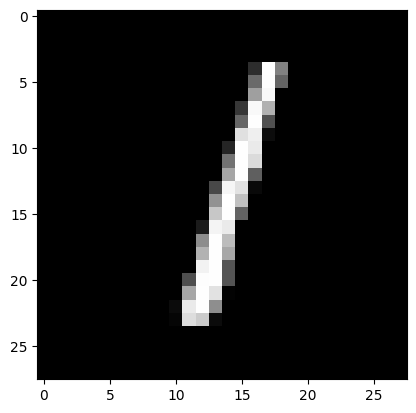

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
[2.1113630e-03 9.7437584e-01 1.7157120e-04 1.7080944e-04 8.8155791e-03
 1.2199727e-03 9.4094435e-03 1.3741275e-03 2.1301073e-03 2.2116273e-04]
1


In [22]:
mnist_og = x_test[2]
plt.imshow(mnist_og, cmap=cm.Greys_r)
plt.show()
# print(mnist_og.reshape(28,28))
# mnist_og
mnist_og.shape
mnist_og = np.expand_dims(mnist_og, axis=0)
# print(mnist_og)
prediction = model.predict(mnist_og)
print(prediction[0])
print(np.argmax(prediction[0]))

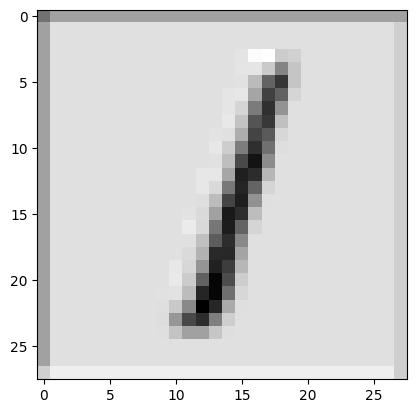

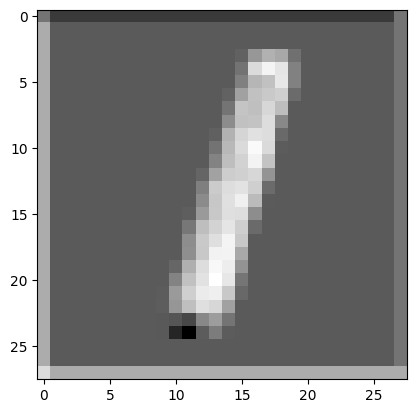

[[ 0.     2.     2.     2.     2.     2.     2.     2.     2.     2.
   2.     2.     2.     2.     2.     2.     2.     2.     2.     2.
   2.     2.     2.     2.     2.     2.     2.     2.   ]
 [ 2.     5.     5.     5.     5.     5.     5.     5.     5.     5.
   5.     5.     5.     5.     5.     5.     5.     5.     5.     5.
   5.     5.     5.     5.     5.     5.     5.     4.   ]
 [ 2.     5.     5.     5.     5.     5.     5.     5.     5.     5.
   5.     5.     5.     5.     5.     5.     5.     5.     5.     5.
   5.     5.     5.     5.     5.     5.     5.     4.   ]
 [ 2.     5.     5.     5.     5.     5.     5.     5.     5.     5.
   5.     5.     5.     5.     5.     5.298  7.29   7.549  3.863  4.145
   5.     5.     5.     5.     5.     5.     5.     4.   ]
 [ 2.     5.     5.     5.     5.     5.     5.     5.     5.     5.
   5.     5.     5.     5.     5.     5.384  5.369  3.792  0.82   3.502
   5.     5.     5.     5.     5.     5.     5.     4.   ]
 [ 2.    

In [23]:
base_input = model.layers[0].input
layer1_output1_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[0].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1), 3)
layer1_output2_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[0].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1), 3)
plt.imshow(layer1_output1_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer1_output2_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
print(layer1_output1_np.reshape((28,28)))

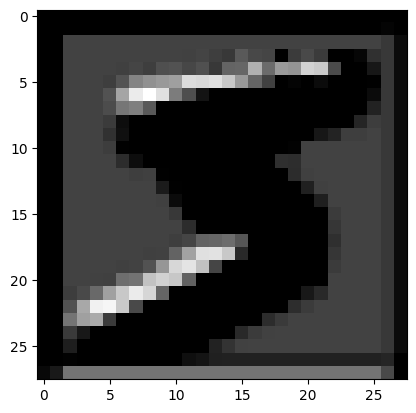

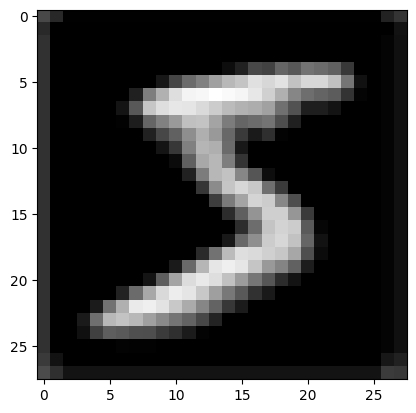

[[0.943 0.567 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026
  0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026 0.026
  0.026 0.026 0.491 0.704]
 [0.579 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.265]
 [0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.077 0.24 ]
 [0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.077 0.24 ]
 [0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.197 0.475 0.936 0.876 1.363 1.151 1.56  1.443 1.3   0.764
  0.    0.    0.077 0.24 ]
 [0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.34  0.907 1.437
  1.773 2.233 2.548 2.753 3.309 3.094 3.35  2.712 3.107 3.094 2.686 1.61

In [8]:
base_input = model.layers[0].input
layer1_output1_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[5].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1), 3)
layer1_output2_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[5].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1), 3)
plt.imshow(layer1_output1_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer1_output2_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
print(layer1_output2_np.reshape((28,28)))

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    for weight in weights:
        print(weight)

In [ ]:
conv1_weights = model.get_layer('conv1').get_weights()[0][:, :, 0, 3]
print("Unique weight values after binarization:", tf.sign(conv1_weights).numpy())

In [ ]:
conv1_weights = model.get_layer('batchnormalize1').get_weights()[:,:,0,0]
print("Unique weight values after binarization:", conv1_weights)

# Calculate network

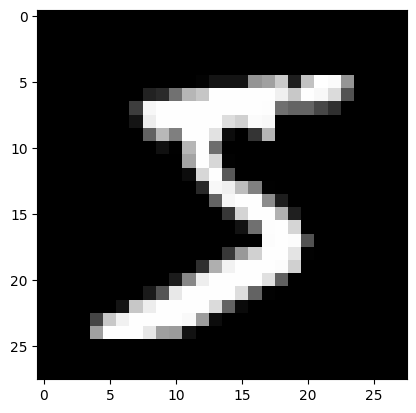

In [6]:
test = x_train[0]
plt.imshow(test, cmap=cm.Greys_r)
plt.show()
test = np.pad(test.reshape((28,28)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))

## Conv1 + BM + RelU

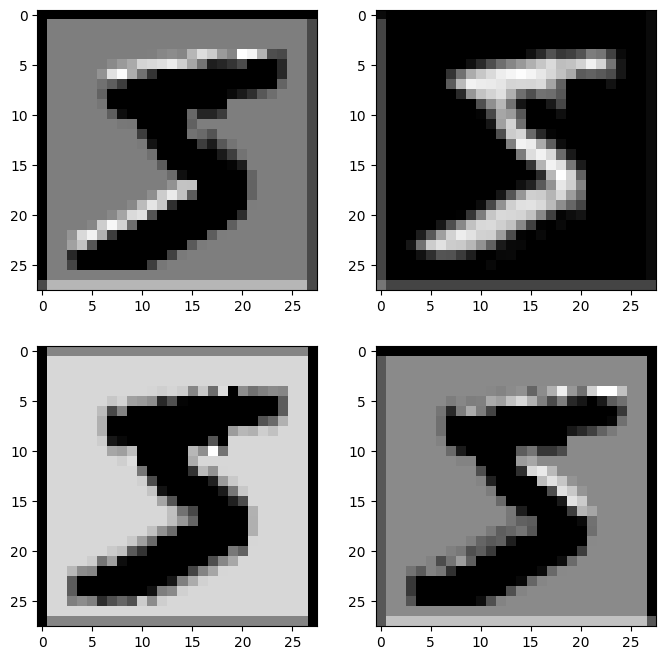

In [8]:
size_k = 4
a = np.zeros((size_k ,28,28))
for i in range(28):
    for j in range(28):
        for k in range(size_k):
            a[k][i][j]= np.sum(test.reshape((30,30))[i:i+3,j:j+3]*tf.sign(model.layers[0].get_weights()[0][:, :, 0, k]))
            a[k][i][j] = (a[k][i][j]-model.layers[1].get_weights()[2][k])/np.sqrt(model.layers[1].get_weights()[3][k])*model.layers[1].get_weights()[0][k]+model.layers[1].get_weights()[1][k]
            if a[k][i][j] < 0: a[k][i][j]=0

# for k in range(size_k):
#     plt.imshow(a[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(a[0], cmap=cm.Greys_r)
axes[0,1].imshow(a[1], cmap=cm.Greys_r)
axes[1,0].imshow(a[2], cmap=cm.Greys_r)
axes[1,1].imshow(a[3], cmap=cm.Greys_r)
plt.show()

## Conv2 + BM + RelU

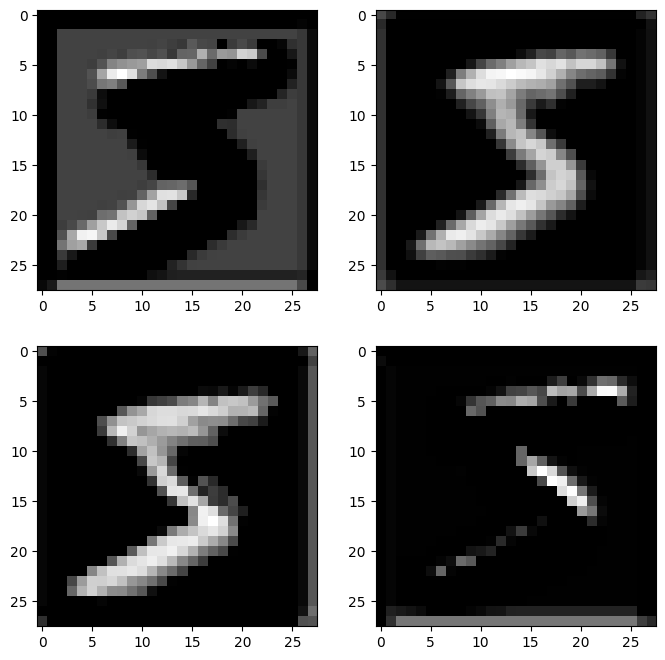

In [9]:
size_k = 4
size_w = 4
aa = np.zeros((size_k ,30,30))
for k in range(size_w):
    aa[k] = np.pad(a[k].reshape((28,28)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
b = np.zeros((size_k ,28,28))
for i in range(28):
    for j in range(28):
        for k in range(size_k):
            for w in range(size_w):
                b[k][i][j] = b[k][i][j] + np.sum(aa[w][i:i+3,j:j+3]*tf.sign(model.layers[3].get_weights()[0][:, :,w, k]))
            b[k][i][j] = (b[k][i][j]-model.layers[4].get_weights()[2][k])/np.sqrt(model.layers[4].get_weights()[3][k])*model.layers[4].get_weights()[0][k]+model.layers[4].get_weights()[1][k]
            if b[k][i][j] < 0: b[k][i][j]=0

# for k in range(size_k):
#     plt.imshow(b[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(b[0], cmap=cm.Greys_r)
axes[0,1].imshow(b[1], cmap=cm.Greys_r)
axes[1,0].imshow(b[2], cmap=cm.Greys_r)
axes[1,1].imshow(b[3], cmap=cm.Greys_r)
plt.show()

## Maxpool1

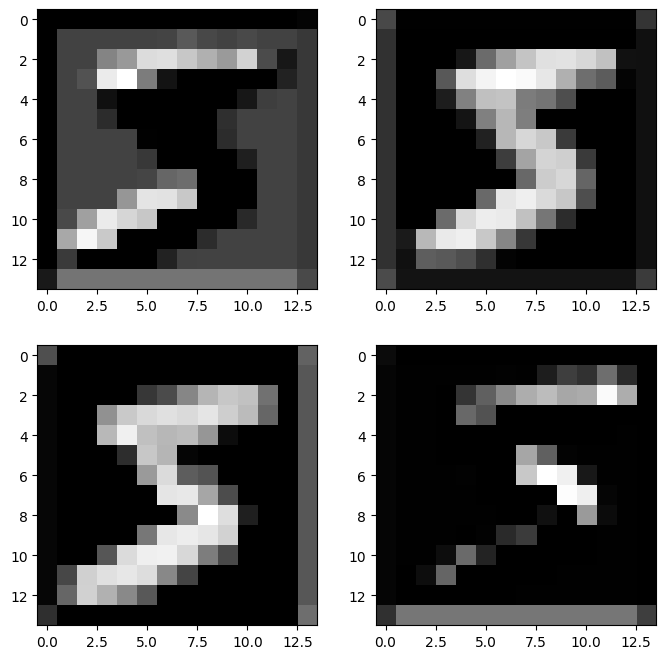

In [10]:
size_k = 4
c = np.zeros((size_k ,14,14))
for i in range(14):
    for j in range(14):
        for k in range(size_k):
            c[k][i][j]= np.max(b[k][2*i:2*i+2,2*j:2*j+2])

# for k in range(size_k):
#     plt.imshow(c[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(c[0], cmap=cm.Greys_r)
axes[0,1].imshow(c[1], cmap=cm.Greys_r)
axes[1,0].imshow(c[2], cmap=cm.Greys_r)
axes[1,1].imshow(c[3], cmap=cm.Greys_r)
plt.show()

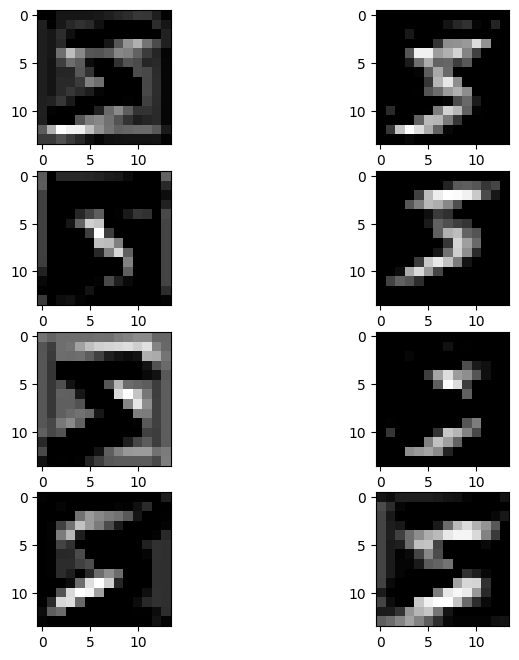

In [11]:
size_k = 8
size_w = 4
cc = np.zeros((size_w ,16,16))
for w in range(size_w):
    cc[w] = np.pad(c[w].reshape((14,14)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
d = np.zeros((size_k ,14,14))
for i in range(14):
    for j in range(14):
        for k in range(size_k):
            for w in range(size_w):
                d[k][i][j] = d[k][i][j] + np.sum(cc[w][i:i+3,j:j+3]*tf.sign(model.layers[7].get_weights()[0][:, :,w, k]))
            d[k][i][j] = (d[k][i][j]-model.layers[8].get_weights()[2][k])/np.sqrt(model.layers[8].get_weights()[3][k])*model.layers[8].get_weights()[0][k]+model.layers[8].get_weights()[1][k]
            if d[k][i][j] < 0: d[k][i][j]=0

# for k in range(size_k):
#     plt.imshow(d[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes[0,0].imshow(d[0], cmap=cm.Greys_r)
axes[0,1].imshow(d[1], cmap=cm.Greys_r)
axes[1,0].imshow(d[2], cmap=cm.Greys_r)
axes[1,1].imshow(d[3], cmap=cm.Greys_r)

axes[2,0].imshow(d[4], cmap=cm.Greys_r)
axes[2,1].imshow(d[5], cmap=cm.Greys_r)
axes[3,0].imshow(d[6], cmap=cm.Greys_r)
axes[3,1].imshow(d[7], cmap=cm.Greys_r)
plt.show()

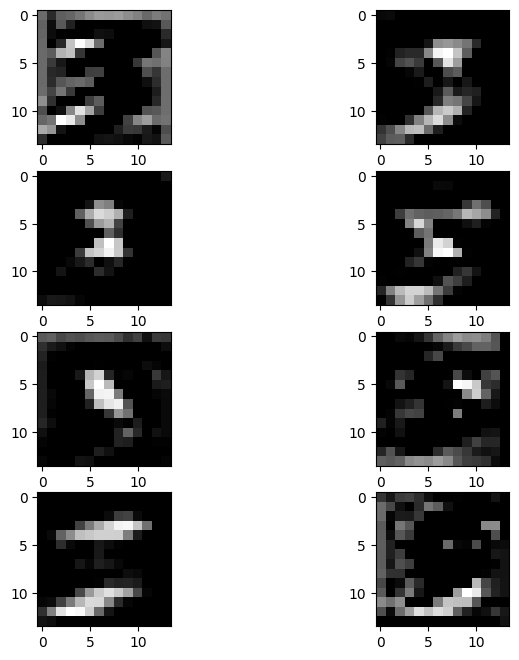

In [12]:
size_k = 8
size_w = 8
dd = np.zeros((size_k ,16,16))
for w in range(size_w):
    dd[w] = np.pad(d[w].reshape((14,14)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
e = np.zeros((size_k ,14,14))
for i in range(14):
    for j in range(14):
        for k in range(size_k):
            for w in range(size_w):
                e[k][i][j] = e[k][i][j] + np.sum(dd[w][i:i+3,j:j+3]*tf.sign(model.layers[10].get_weights()[0][:, :,w, k]))
            e[k][i][j] = (e[k][i][j]-model.layers[11].get_weights()[2][k])/np.sqrt(model.layers[11].get_weights()[3][k])*model.layers[11].get_weights()[0][k]+model.layers[11].get_weights()[1][k]
            if e[k][i][j] < 0: e[k][i][j]=0

# for k in range(size_k):
#     plt.imshow(e[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes[0,0].imshow(e[0], cmap=cm.Greys_r)
axes[0,1].imshow(e[1], cmap=cm.Greys_r)
axes[1,0].imshow(e[2], cmap=cm.Greys_r)
axes[1,1].imshow(e[3], cmap=cm.Greys_r)

axes[2,0].imshow(e[4], cmap=cm.Greys_r)
axes[2,1].imshow(e[5], cmap=cm.Greys_r)
axes[3,0].imshow(e[6], cmap=cm.Greys_r)
axes[3,1].imshow(e[7], cmap=cm.Greys_r)
plt.show()

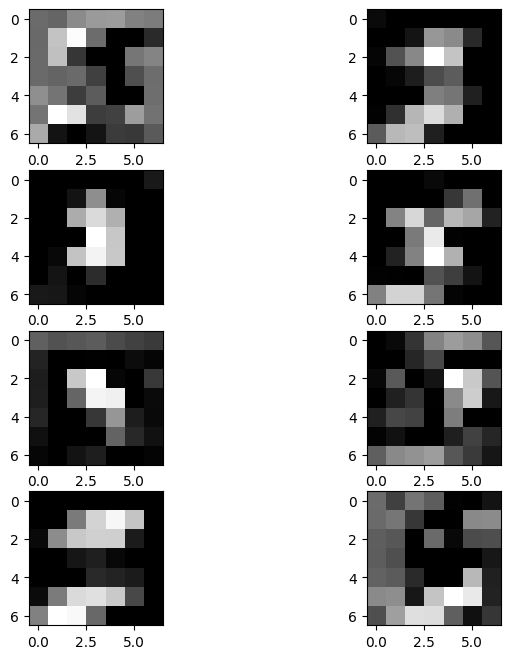

In [13]:
size_k = 8
f = np.zeros((size_k ,7,7))
for i in range(7):
    for j in range(7):
        for k in range(size_k):
            f[k][i][j]= np.max(e[k][2*i:2*i+2,2*j:2*j+2])

# for k in range(size_k):
#     plt.imshow(f[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes[0,0].imshow(f[0], cmap=cm.Greys_r)
axes[0,1].imshow(f[1], cmap=cm.Greys_r)
axes[1,0].imshow(f[2], cmap=cm.Greys_r)
axes[1,1].imshow(f[3], cmap=cm.Greys_r)

axes[2,0].imshow(f[4], cmap=cm.Greys_r)
axes[2,1].imshow(f[5], cmap=cm.Greys_r)
axes[3,0].imshow(f[6], cmap=cm.Greys_r)
axes[3,1].imshow(f[7], cmap=cm.Greys_r)
plt.show()

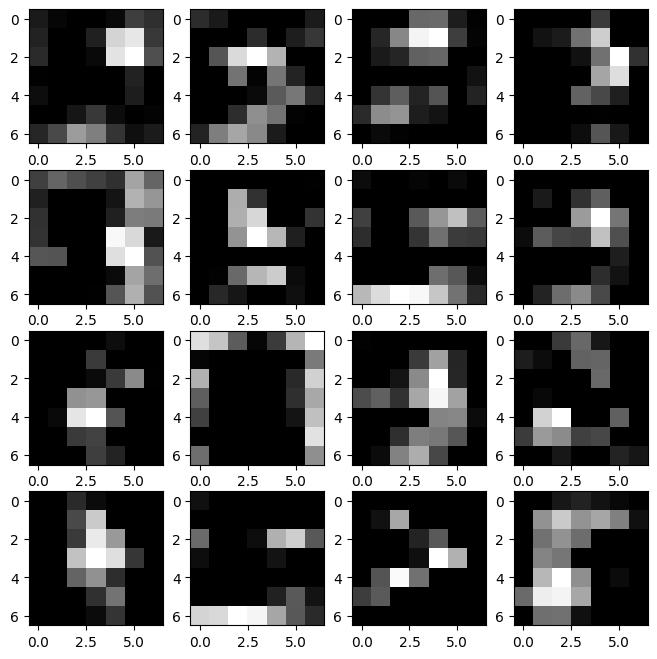

In [14]:
size_k = 16
size_w = 8
ff = np.zeros((size_w ,9,9))
for w in range(size_w):
    ff[w] = np.pad(f[w].reshape((7,7)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
g = np.zeros((size_k ,7,7))
for i in range(7):
    for j in range(7):
        for k in range(size_k):
            for w in range(size_w):
                g[k][i][j] = g[k][i][j] + np.sum(ff[w][i:i+3,j:j+3]*tf.sign(model.layers[14].get_weights()[0][:, :,w, k]))
            g[k][i][j] = (g[k][i][j]-model.layers[15].get_weights()[2][k])/np.sqrt(model.layers[15].get_weights()[3][k])*model.layers[15].get_weights()[0][k]+model.layers[15].get_weights()[1][k]
            if g[k][i][j] < 0: g[k][i][j]=0

# for k in range(size_k):
#     plt.imshow(g[k], cmap=cm.Greys_r)
#     plt.show()
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes[0,0].imshow(g[0], cmap=cm.Greys_r)
axes[0,1].imshow(g[1], cmap=cm.Greys_r)
axes[1,0].imshow(g[2], cmap=cm.Greys_r)
axes[1,1].imshow(g[3], cmap=cm.Greys_r)

axes[2,0].imshow(g[4], cmap=cm.Greys_r)
axes[2,1].imshow(g[5], cmap=cm.Greys_r)
axes[3,0].imshow(g[6], cmap=cm.Greys_r)
axes[3,1].imshow(g[7], cmap=cm.Greys_r)

axes[0,2].imshow(g[8], cmap=cm.Greys_r)
axes[0,3].imshow(g[9], cmap=cm.Greys_r)
axes[1,2].imshow(g[10], cmap=cm.Greys_r)
axes[1,3].imshow(g[11], cmap=cm.Greys_r)

axes[2,2].imshow(g[12], cmap=cm.Greys_r)
axes[2,3].imshow(g[13], cmap=cm.Greys_r)
axes[3,2].imshow(g[14], cmap=cm.Greys_r)
axes[3,3].imshow(g[15], cmap=cm.Greys_r)
plt.show()

## Global Maxpool

In [15]:
size_k = 16
h = np.zeros((size_k))
for k in range(size_k):
    h[k]= np.max(g[k])

print(h)

[5.36134192 3.90686803 3.19106441 4.37567185 4.36000084 1.56711426
 2.94919049 3.64318054 5.88770314 1.82071261 5.06273605 5.48654882
 4.55651431 2.60375804 2.17327976 4.80474815]


In [20]:
i = np.array([])
for k in range(10):
    i = np.append(i,np.sum(np.round(model.layers[18].get_weights()[0][:, k], 3)*h) + np.round(model.layers[18].get_weights()[1][k], 3))
print(i)

[-3.31942869 -4.64194528 -3.26262218 -2.66285323 -7.58980373  4.73886275
 -4.59654636 -3.97840844 -2.17032752 -3.48595106]


In [21]:
np.argmax(i)

np.int64(5)

# Extract Weight

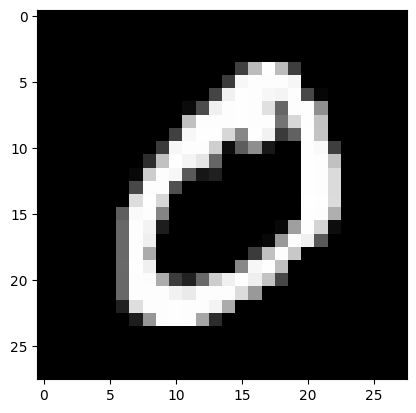

0


In [9]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

plt.imshow(x_train[1], cmap=cm.Greys_r)
plt.show()
print(x_train[1])

In [21]:
f = open("demofile2.txt", "w")
cnt = 0
i = 0
while (cnt<10):
    if(y_test[i] == cnt):
        print(cnt)
        cnt +=1
        for j in range(28):
            for k in range(28):
                f.write("%0.2X" % x_test[i][j][k]+'\n')
    i+=1

f.close()

0
1
2
3
4
5
6
7
8
9


In [9]:
size_k = 4
for k in range(size_k):
    t = np.array(tf.sign(model.layers[0].get_weights()[0][:, :, 0, k])).flatten()
    # print(t)
    # print("{:04b}".format(k), end="") #kernel id
    # print("{:03b}".format(0), end="") #window id
    for tt in t:
        if tt == -1:
            print('1', end="")
        else: print('0', end="")
    print('')

111111100
011000000
101111101
111111001


In [10]:
size_k = 4
size_w = 4
for k in range(size_k):
    for w in range(size_w):
        t = np.array(tf.sign(model.layers[3].get_weights()[0][:, :, w, k])).flatten()
        # print("{:04b}".format(k), end="") #kernel id
        # print("{:03b}".format(w), end="") #window id
        for tt in t:
            if tt == -1:
                print('1', end="")
            else: print('0', end="")
        print('')

000000101
111110100
010001010
100101111
000111111
101000000
101111111
101111101
010011011
100110001
101111111
001111111
100010111
110011001
000010111
011000100


In [11]:
size_k = 8
size_w = 4
for k in range(size_k):
    for w in range(size_w):
        t = np.array(tf.sign(model.layers[7].get_weights()[0][:, :, w, k])).flatten()
        # print("{:04b}".format(k), end="") #kernel id
        # print("{:03b}".format(w), end="") #window id
        for tt in t:
            if tt == -1:
                print('1', end="")
            else: print('0', end="")
        print('')

000110000
000101111
100110111
010010000
001111100
000111010
000000100
100100001
111111011
100101100
001101101
110110111
111010111
011000000
110100000
010010001
011011010
111011100
111101011
001001000
000100110
001011000
000011111
111111100
000000001
110101001
110100001
110111111
110110011
000000111
000111111
101011111


In [12]:
size_k = 8
size_w = 8
for k in range(size_k):
    for w in range(size_w):
        t = np.array(tf.sign(model.layers[10].get_weights()[0][:, :, w, k])).flatten()
        # print("{:04b}".format(k), end="") #kernel id
        # print("{:03b}".format(w), end="") #window id
        for tt in t:
            if tt == -1:
                print('1', end="")
            else: print('0', end="")
        print('')

011110101
111110000
111111100
110110111
101111000
100100110
110000011
001101111
110110110
100000011
010010001
010010101
111111110
000000000
000101111
110110110
110111111
000000010
111011000
000111000
111111011
011011001
001000110
101111111
001000110
000000111
001100111
000111000
110111011
111111110
010010010
101001111
111111111
010001010
100000000
000100111
111110010
100110111
101111110
010010111
000100111
011010110
011110110
101001000
110111000
000001010
010010111
111111111
110000110
111000000
111111111
000000111
111111100
110100111
101100111
000000010
111001100
011011111
001011110
111111100
101110110
000000001
000100001
100101010


In [13]:
size_k = 16
size_w = 8
for k in range(size_k):
    for w in range(size_w):
        t = np.array(tf.sign(model.layers[14].get_weights()[0][:, :, w, k])).flatten()
        # print("{:04b}".format(k), end="") #kernel id
        # print("{:03b}".format(w), end="") #window id
        for tt in t:
            if tt == -1:
                print('1', end="")
            else: print('0', end="")
        print('')

010100100
101011011
110011011
111001000
110111001
111000000
001000011
011110111
111111000
010000100
001111111
111010010
110000100
000111111
000000011
010111000
100010000
011011111
001010111
111001001
011001111
000100100
011011001
001111101
001000111
000100110
000110000
001011001
001000100
101011011
011100011
111000111
011111101
001110000
100100000
000000111
100110000
111001000
001011000
011000100
111011001
101110011
001101011
101101101
111001001
110011001
111110111
110111101
011111001
001100000
000111000
000011111
100100000
001101110
001100110
111010111
111100111
000110111
001101101
110000111
011111111
011000100
001000111
110110111
001001001
111001001
111000001
010110100
101101001
100101101
101000000
100011011
100110101
100001000
101000000
001010110
111111000
000000001
011111001
000000111
110100111
000101101
111101100
001001111
011111111
001000101
000000101
110110111
011110100
000011000
001011000
100110110
011011000
100000000
100100111
000001111
110111010
000001001
000111000
100111110


In [7]:
def int_to_twos_complement_format(num, bits):
    mask = (1 << bits) - 1
    return "{:0{}b}".format(num & mask, bits)

In [17]:
layer = 1
size_k = 4
for k in range(size_k):
    mean = model.layers[layer].get_weights()[2][k]
    std = np.sqrt(model.layers[layer].get_weights()[3][k])
    gamma = model.layers[layer].get_weights()[0][k]
    beta = model.layers[layer].get_weights()[1][k]
    #Batch normalize yi = gamma*(xi-mean)/sqrt(variance) + beta
    # print("{:04b}".format(k), end="") #kernel id
    # theta = round(256*gamma/std)
    # print("{:012b}".format(theta))
    
    # print("{:04b}".format(k), end="") #kernel id
    phi = round((-mean*gamma/std + beta)*256)
    print(int_to_twos_complement_format(phi,12))

111100000111
000101110110
111011110001
111100001000


In [19]:
layer = 4
size_k = 4
for k in range(size_k):
    mean = model.layers[layer].get_weights()[2][k]
    std = np.sqrt(model.layers[layer].get_weights()[3][k])
    gamma = model.layers[layer].get_weights()[0][k]
    beta = model.layers[layer].get_weights()[1][k]
    #Batch normalize yi = gamma*(xi-mean)/sqrt(variance) + beta
    # print("{:04b}".format(k), end="") #kernel id
    theta = round(256*gamma/std)
    # print("{:012b}".format(theta))
    
    # print("{:04b}".format(k), end="") #kernel id
    phi = round((-mean*gamma/std + beta)*256)
    print(int_to_twos_complement_format(phi,12))

111110011011
000100110111
000100011001
111101001000


In [21]:
layer = 8
size_k = 8
for k in range(size_k):
    mean = model.layers[layer].get_weights()[2][k]
    std = np.sqrt(model.layers[layer].get_weights()[3][k])
    gamma = model.layers[layer].get_weights()[0][k]
    beta = model.layers[layer].get_weights()[1][k]
    #Batch normalize yi = gamma*(xi-mean)/sqrt(variance) + beta
    # print("{:04b}".format(k), end="") #kernel id
    theta = round(256*gamma/std)
    print("{:012b}".format(theta))
    
    # print("{:04b}".format(k), end="") #kernel id
    phi = round((-mean*gamma/std + beta)*256)
    # print(int_to_twos_complement_format(phi,12))

000000111100
000000111000
000000101011
000000100000
000000101100
000000110000
000000100000
000000101011


In [23]:
layer = 11
size_k = 8
for k in range(size_k):
    mean = model.layers[layer].get_weights()[2][k]
    std = np.sqrt(model.layers[layer].get_weights()[3][k])
    gamma = model.layers[layer].get_weights()[0][k]
    beta = model.layers[layer].get_weights()[1][k]
    #Batch normalize yi = gamma*(xi-mean)/sqrt(variance) + beta
    # print("{:04b}".format(k), end="") #kernel id
    theta = round(256*gamma/std)
    print("{:012b}".format(theta))
    
    # print("{:04b}".format(k), end="") #kernel id
    phi = round((-mean*gamma/std + beta)*256)
    # print(int_to_twos_complement_format(phi,12))

000000101100
000000100010
000000110000
000000100100
000000100100
000000101000
000000100010
000000101011


In [25]:
layer = 15
size_k = 16
for k in range(size_k):
    mean = model.layers[layer].get_weights()[2][k]
    std = np.sqrt(model.layers[layer].get_weights()[3][k])
    gamma = model.layers[layer].get_weights()[0][k]
    beta = model.layers[layer].get_weights()[1][k]
    #Batch normalize yi = gamma*(xi-mean)/sqrt(variance) + beta
    # print("{:04b}".format(k), end="") #kernel id
    theta = round(256*gamma/std)
    # print("{:012b}".format(theta))
    
    # print("{:04b}".format(k), end="") #kernel id
    phi = round((-mean*gamma/std + beta)*256)
    print(int_to_twos_complement_format(phi,12))

000000111111
111111111000
000001111010
111100011101
111010011011
000110101111
111110100100
000100000101
111101000101
111011010001
000100001100
111100001111
000000101110
000000010110
111101011100
111001000001


In [13]:
# for k in range(10):
#     for w in model.layers[18].get_weights()[0][:, k]:
#         # print("{:04b}".format(k), end="") #kernel id
#         weight = round(256*w)
#         print(int_to_twos_complement_format(weight,12))

for w in range(16):
    for k in range(10):
        temp = model.layers[18].get_weights()[0][:, k][w]
        # print("{:04b}".format(k), end="") #kernel id
        weight = round(256*temp)
        print(int_to_twos_complement_format(weight,12), end='')
    print('')


111101011010000000010000111101110001111110011011111101110101000011000101111111100100111111000011111101111110111111111101
000000110100111110010001000001110011111101101100000011100010111111100001111111010011000001011000111101011010000000111110
111110101010000001100000000011001100111111110010000000101101111111010101111111110100111110111001000001011100111101010000
111101001111000000010010111101101101000011001111000000001010000000010101111110110011111110110001111111111001000001101001
000010010101111101000000000010111100000001000110111110011100111111110000111111010011000001010110111110101000000000010111
000000101101000000100101111111110010111111011111000001101101111100110110111111101101000001011010111110110110000001100110
111111010111111111011001000001011001111111111110111101101110111100001011111101000110000010110000000010100000111111001001
000001010101111111111001000001111111000001100111111101001010000000001011000001001011111110000000000000110011111101010101
00000010111111110011001011111110

In [27]:
for k in range(10):
    w = model.layers[18].get_weights()[1][k]
    # print("{:04b}".format(k), end="") #kernel id
    weight = round(256*w)
    print(int_to_twos_complement_format(weight,12))

111111010001
000001101111
111111101110
111111111100
000000000110
111111010110
111111101001
000000001000
111111101110
111111100111
